In [1]:
import os
os.environ['PYTHONHASHSEED']=str(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.set_random_seed(0)

# ## uncomment for reproducibility ##
# from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

import pandas as pd
import matplotlib.pyplot as plt
import pickle
import itertools
import time
import itertools

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.initializers import glorot_uniform

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.svm import SVC
from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours
from sklearn.ensemble import RandomForestClassifier as RFC

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
version = '05'

Using TensorFlow backend.


In [2]:
def play_bell():
    import winsound
    duration = 200  # millisecond
    freq = 440  # Hz
    for i in range(5):
        winsound.Beep(int(freq*(i/2+1)), duration)

## Dataset loading

In [3]:
right = pd.read_csv("../data/right.txt", header=None).values.tolist()
left = pd.read_csv("../data/left.txt", header=None).values.tolist()

## Pre-processing

In [4]:
batch_size = 200
batch_right = [right[i:i + batch_size] for i in range(0, len(right), batch_size)]
batch_left = [left[i:i + batch_size] for i in range(0, len(left), batch_size)]

X_load = np.array(batch_right + batch_left)
y_load = np.array([0]*len(batch_right) + [1]*len(batch_left))

In [5]:
print(f'X shape: {X_load.shape}\ny shape: {y_load.shape}')

X shape: (600, 200, 2)
y shape: (600,)


In [6]:
X_diff = X_load[:,:-1,:].copy()
X_diff[:,:,0] = np.diff(X_load[:,:,0])
X_diff[:,:,1] = np.diff(X_load[:,:,1])

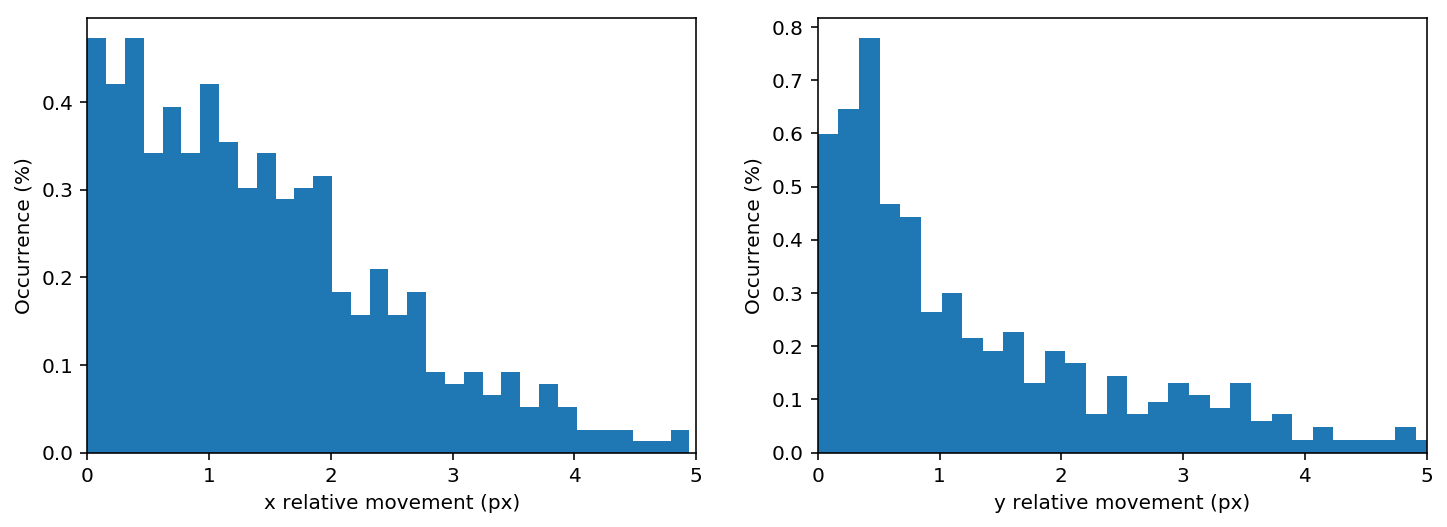

In [7]:
sigma_x = np.std(X_diff[:,:,0], axis=1)
sigma_y = np.std(X_diff[:,:,1], axis=1)
mask = (sigma_x>0.1)*(sigma_y>0.1)

X_filt = X_diff[mask]
y_filt = y_load[mask]

x_std = 3.398 # np.mean(np.std(X_filt[:,:,0], axis=1))
y_std = 2.926 # np.mean(np.std(X_filt[:,:,1], axis=1))

X_filt[:,:,0] = X_filt[:,:,0] / x_std
X_filt[:,:,1] = X_filt[:,:,1] / y_std

sigma_x_filt = np.std(X_filt[:,:,0], axis=1)
sigma_y_filt = np.std(X_filt[:,:,1], axis=1)


fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(12, 4))
ax1.hist(sigma_x_filt, bins=50, density=True)
ax2.hist(sigma_y_filt, bins=50, density=True)
for ax in (ax1,ax2):
    ax.set_xlim(0,5)
    ax.set_ylabel('Occurrence (%)')
    #ax.set_yticks(np.arange(0,0.41,0.1))
ax1.set_xlabel('x relative movement (px)')
ax2.set_xlabel('y relative movement (px)')

X = X_filt
y = y_filt

#fig.savefig(f'../plots/relative_movement_hist_corrected.png', bbox_inches='tight')

## Model definition

In [8]:
def create_train_test(X, y):
    X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.15, random_state=0, shuffle=True)   
    nsamples, nx, ny = X_train_dev.shape
    X_train_dev_2D = X_train_dev.reshape((nsamples,nx*ny))
    
    nsamples, nx, ny = X_test.shape
    X_test_2D = X_test.reshape((nsamples,nx*ny))
    
    return X_train_dev_2D, X_test_2D, y_train_dev, y_test
    
def svc_cv(C, gamma, data, targets):
    estimator = SVC(C=C, gamma=gamma, random_state=2)
    cval = cross_val_score(estimator, data, targets, scoring='roc_auc', cv=4)
    return cval.mean()


def optimize_svc(data, targets):
    """Apply Bayesian Optimization to SVC parameters."""
    def svc_crossval(expC, expGamma):
        """Wrapper of SVC cross validation.
        Notice how we transform between regular and log scale. While this
        is not technically necessary, it greatly improves the performance
        of the optimizer.
        """
        C = 10 ** expC
        gamma = 10 ** expGamma
        return svc_cv(C=C, gamma=gamma, data=data, targets=targets)

    optimizer = BayesianOptimization(
        f=svc_crossval,
        pbounds={"expC": (-3, 2), "expGamma": (-4, -1)},
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=50)
    print("Final result:", optimizer.max)


In [73]:
np.random.seed(grid['seed_numpy'][1])
tf.set_random_seed(grid['seed_tensorflow'][1])
random.seed(grid['seed_random'][1])

X_train, X_test, y_train, y_test = create_train_test(X, y)

optimize_svc(X_train, y_train)

|   iter    |  target   |   expC    | expGamma  |
-------------------------------------------------
|  1        |  0.6169   | -2.042    | -2.134    |
|  2        |  0.6065   | -0.8114   | -1.644    |
|  3        |  0.5856   |  0.8999   | -3.182    |
|  4        |  0.5963   | -1.618    | -1.594    |
|  5        |  0.5253   |  1.791    | -1.372    |
|  6        |  0.5806   | -3.0      | -4.0      |
|  7        |  0.5805   | -1.084    | -4.0      |
|  8        |  0.6222   | -0.9358   | -2.697    |
|  9        |  0.6218   | -3.0      | -2.238    |
|  10       |  0.6219   | -2.998    | -2.853    |
|  11       |  0.602    | -0.04574  | -2.373    |
|  12       |  0.5523   |  2.0      | -4.0      |
|  13       |  0.6218   | -1.93     | -2.926    |
|  14       |  0.6204   | -1.428    | -2.505    |
|  15       |  0.6217   | -2.563    | -2.603    |
|  16       |  0.6204   | -2.998    | -2.574    |
|  17       |  0.5913   | -3.0      | -1.0      |
|  18       |  0.6219   | -1.279    | -2.938    |
